In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from timeit import default_timer as timer
from datetime import datetime
from scipy.stats import moment
from copy import deepcopy
from tqdm import tqdm
import pickle

import sys
from os.path import dirname, abspath
import os
sys.path.append(dirname(dirname(abspath('__file__')))+'/utils')

from sklearn.model_selection import train_test_split

from check_performance import checkPerformance
from line_suppression import seg_line_sup
from read_answers import ReadAnswers

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
## Input the filenames and parameters:
filename =  'AmsData_hoge_corrected_int_all.pkl' # 
original_indices = 'orig_x.npy'
full_indices = 'full_time_index.npy'
filename_answers = 'hoge_segm_lines_31052020.txt' #'lage_segm_lines_31052020.txt'
interpolation_method = 'linear'

## Create variables with directories to external files:
directory = os.path.join(dirname(os.getcwd()), 'data_files/')
file_data = os.path.join(directory, filename)
file_full_indices = os.path.join(directory, full_indices)
file_orig_indices = os.path.join(directory, original_indices)
file_answers = os.path.join(directory, filename_answers)

## Import the measurements:
data_imported = pd.read_pickle(file_data)
mydata = data_imported[interpolation_method].copy()

## Load and calculate x-axis index:
orig_x = np.load(file_orig_indices)
full_x = np.load(file_full_indices) 
indices = [int(i*365.25/11) for i in orig_x]

## Load the answers (ground truth):
answers = ReadAnswers(file_answers)
ans = pd.DataFrame(answers['segm_lines'], index = answers.index)
ans.columns = ['segm']
## For full time T-S:
for i in range(100):
    ans.segm.iloc[i] = [indices[y] for y in ans.segm.iloc[i]]

## Mask to choose only the examples with provided GT (ground truth):
mask_segm = ans.segm.apply(lambda x: x != [])
ans[mask_segm]
ans_segm_only = ans.iloc[np.where(mask_segm)[0]]
mydata_segm_only = mydata.iloc[ans.index[np.where(mask_segm)[0]]].copy()

## Reverse indices using the last existing index
indices_reverse = []
for i in range(297):
    if i in indices:
        indices_reverse.append(i)
    else:
        indices_reverse.append(indices_reverse[i-1])

In [3]:
mydata_segm_only.iloc[70]

2009-02-05     0.0
2009-02-16    -0.1
2009-02-27     0.4
2009-03-10    -1.4
2009-03-21    -0.7
              ... 
2017-11-22   -10.4
2017-12-03   -11.8
2017-12-14   -12.1
2017-12-25   -12.3
2018-01-05   -12.6
Name: 14344, Length: 297, dtype: float64

In [4]:
data_df = mydata_segm_only
segm_lines = ans_segm_only

record_num = len(data_df)
record_length = len(data_df.iloc[0])

## Reshape the data from DataFrame into an array
data = np.zeros((record_num, record_length))
for idx, ar in enumerate(data_df.values):
    data[idx, :] = ar
    data[idx, 0] = 0.0
        
ans_seg = np.zeros((record_num, record_length))
for idx, l in enumerate(segm_lines.values):
    for s in l[0]:
        ans_seg[idx, s] = 1

In [7]:
# with open("raw_real_input_data_ans_seg_ah.pkl", "wb") as file:
#     pickle.dump({"data": data, "ans_seg": ans_seg}, file)

In [5]:
X = data
y = ans_seg
idxs = segm_lines.index.values

##################################################
window_len = 30
shift = 10
num_of_windows = int(np.ceil((297 - window_len)/shift) + 1) #58
print(num_of_windows)

## Reshape the data from DataFrame into an array
data_divided = np.zeros((X.shape[0], num_of_windows, window_len))
for idx, ar in enumerate(X):
    for win in range(num_of_windows):
        inp = ar[shift*win: shift*win+window_len]
        data_divided[idx, win, 0:len(inp)] = inp

y_segm_all_divided = np.zeros((X.shape[0], num_of_windows, window_len))
for idx, ar in enumerate(y):
    for win in range(num_of_windows):
        inp = ar[shift*win: shift*win+window_len]
        y_segm_all_divided[idx, win, 0:len(inp)] = inp

y_segm_divided = np.zeros((X.shape[0], num_of_windows))
for idx, ar in enumerate(y):
    for win in range(num_of_windows):
        y_segm_divided[idx, win] = max(ar[shift*win: shift*win+window_len])


28


In [6]:
indices = []
for i in idxs:
    for w in range(num_of_windows):
        indices.append((i, w))

In [12]:
# with open("indices_real_30_10_ah.pkl", "wb") as file:
#     pickle.dump(indices, file)

In [7]:
df_whole = pd.DataFrame.from_records(X)

Subseries: 0


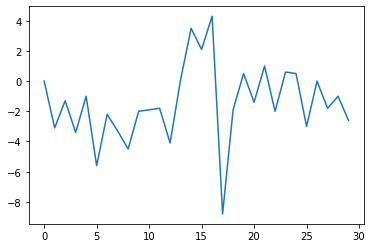

Subseries: 1


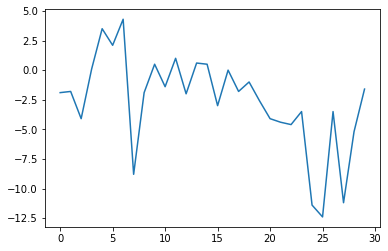

Subseries: 2


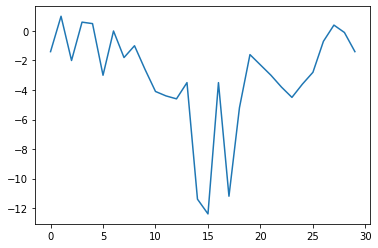

Subseries: 3


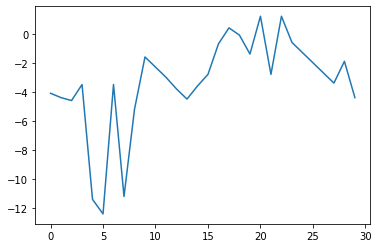

Subseries: 4


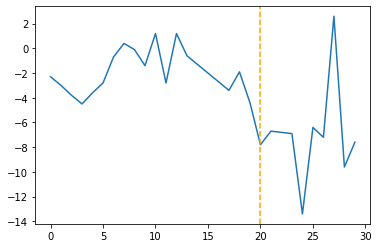

Subseries: 5


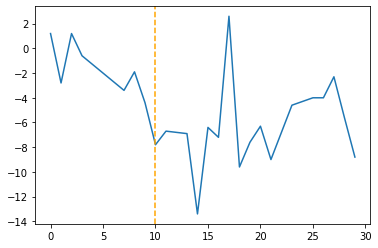

Subseries: 6


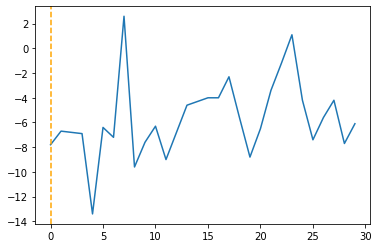

Subseries: 7


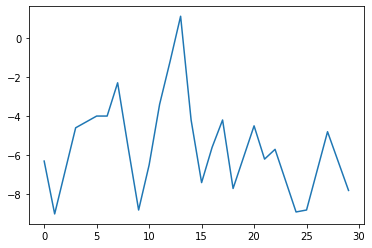

Subseries: 8


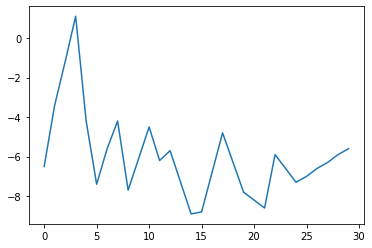

Subseries: 9


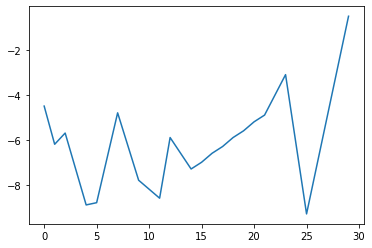

Subseries: 10


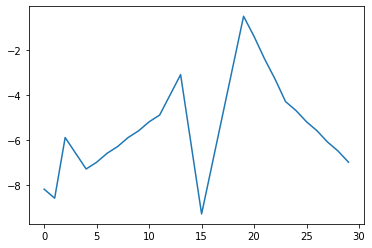

Subseries: 11


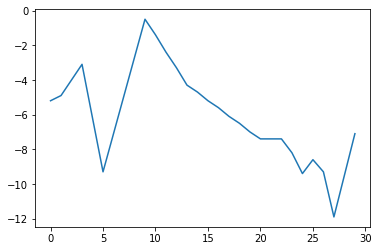

Subseries: 12


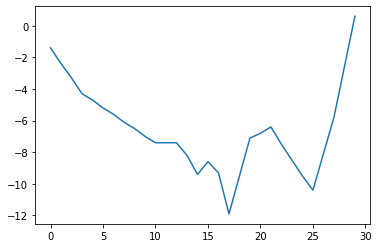

Subseries: 13


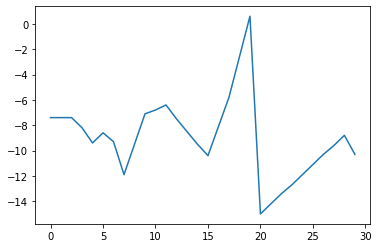

Subseries: 14


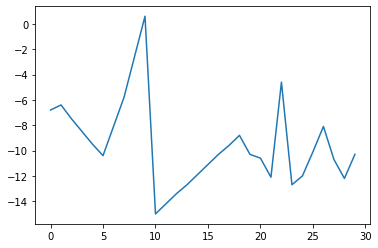

Subseries: 15


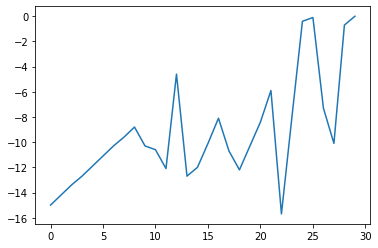

Subseries: 16


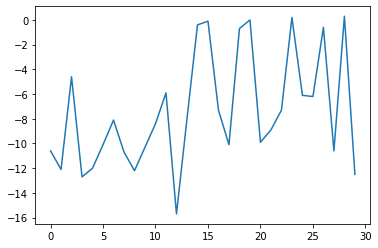

Subseries: 17


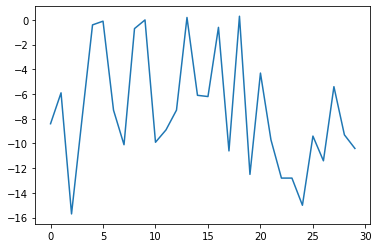

Subseries: 18


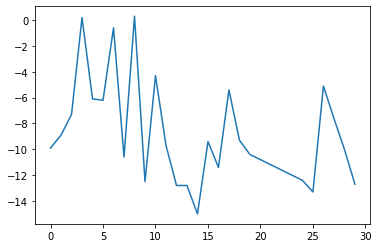

Subseries: 19


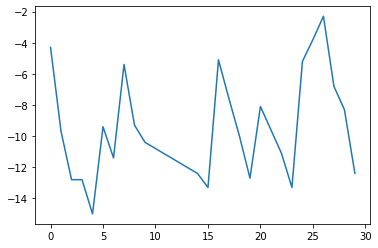

Subseries: 20


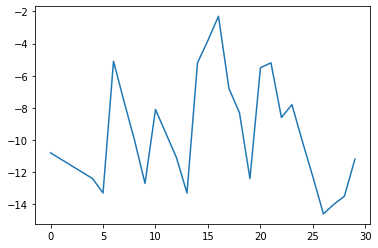

Subseries: 21


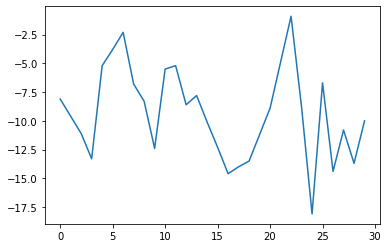

Subseries: 22


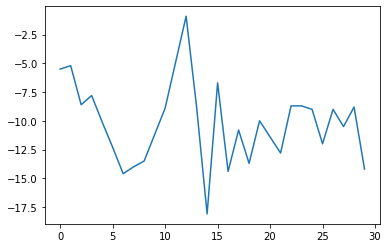

Subseries: 23


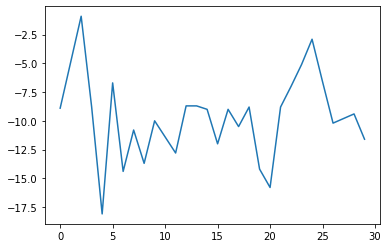

Subseries: 24


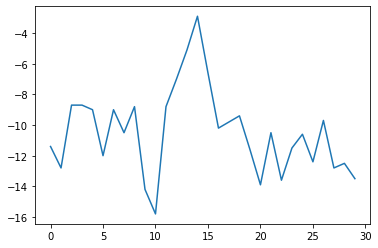

Subseries: 25


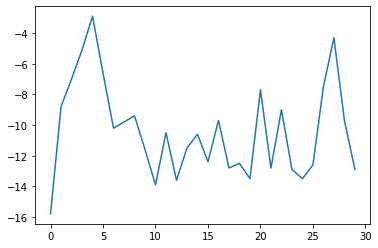

Subseries: 26


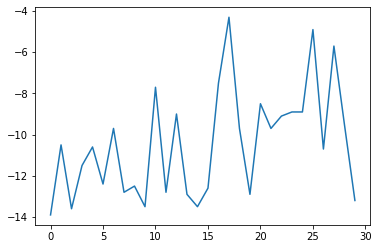

Subseries: 27


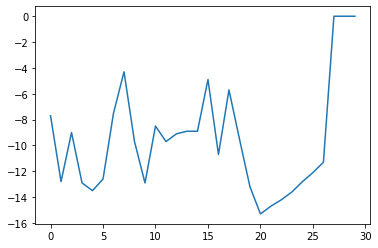

In [11]:
for i in range(data_divided.shape[1]):
    print(f"Subseries: {i}")
    plt.figure()
    plt.plot(data_divided[0][i])
    for j, val in enumerate(y_segm_all_divided[0][i]):
        if val == 1:
            plt.gca().axvline(j, linestyle='--', color='orange')
    plt.show()

In [12]:
dr = data_divided.reshape((-1, 30))

In [13]:
input_dfs = pd.concat([pd.DataFrame(data_divided.reshape((-1, window_len))), 
                                  pd.DataFrame(indices, columns=["ts_id", "win_id"]),
                                  pd.DataFrame(y_segm_divided.reshape(-1).astype(int), columns=["label"])
                                 ], axis=1)

In [14]:
input_dfs

0     1     2     3     4     5     6     7     8     9  ...    23  \
0      0.0  -3.1  -1.3  -3.4  -1.0  -5.6  -2.2  -3.3  -4.5  -2.0  ...   0.6   
1     -1.9  -1.8  -4.1   0.1   3.5   2.1   4.3  -8.8  -1.9   0.5  ...  -3.5   
2     -1.4   1.0  -2.0   0.6   0.5  -3.0   0.0  -1.8  -1.0  -2.6  ...  -4.5   
3     -4.1  -4.4  -4.6  -3.5 -11.4 -12.4  -3.5 -11.2  -5.2  -1.6  ...  -0.6   
4     -2.3  -3.0  -3.8  -4.5  -3.6  -2.8  -0.7   0.4  -0.1  -1.4  ...  -6.9   
...    ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
2067 -11.5 -12.6 -13.7 -12.8 -13.9 -13.1 -15.2 -13.3 -12.9 -12.3  ...  -5.9   
2068 -13.3 -11.7 -11.4 -10.4  -8.7  -7.9  -9.6  -8.1  -9.1 -11.4  ... -13.0   
2069  -9.1  -5.0  -5.4  -5.9  -4.6  -7.5 -10.3 -11.5 -12.7 -13.5  ... -13.3   
2070 -14.3 -12.9 -14.1 -13.0 -16.9 -14.0 -16.2 -13.2 -15.9 -13.9  ... -10.2   
2071 -14.6 -10.4 -12.2 -13.3 -16.0 -11.3  -9.2  -9.9  -9.8 -12.4  ... -13.7   

        24    25    26    27    28    29  ts_id  win_id  label  
0      0.5  -3.0   0.0  -1.8  -1.0  -2.6    783       0      0  
1    -11.4 -12.4  -3.5 -11.2  -5.2  -1.6    783       1      0  
2     -3.6  -2.8  -0.7   0.4  -0.1  -1.4    783       2      0  
3     -1.3  -2.0  -2.7  -3.4  -1.9  -4.4    783       3      0  
4    -13.4  -6.4  -7.2   2.6  -9.6  -7.6    783       4      1  
...    ...   ...   ...   ...   ...   ...    ...     ...    ...  
2067  -4.6  -7.5 -10.3 -11.5 -12.7 -13.5  14939      23      0  
2068 -16.9 -14.0 -16.2 -13.2 -15.9 -13.9  14939      24      0  
2069 -16.0 -11.3  -9.2  -9.9  -9.8 -12.4  14939      25      0  
2070  -7.5  -6.8 -10.0 -22.9 -16.9 -10.9  14939      26      0  
2071 -14.3 -15.0 -15.6   0.0   0.0   0.0  14939      27      0  

[2072 rows x 33 columns]

In [11]:
# with open("raw_subseries_input_dfs_real_30_10_ah.pkl", "wb") as file:
#     pickle.dump(input_dfs, file)